In [212]:
### Import Libarys ###

## libarys ##
import scipy as sp
from scipy import integrate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [213]:
### Market Models ###

## The Market Model
class market_model():
    
    # fixed market parameters
    S0 = 105
    mu = 0.12
    r = 0.04
    
    # max time maturity
    T_max = 1.60
    
    ## market volaitlity
    # t: (float) input time
    def sigma(self, t):
        
        if t > 0.5:
            return 0.13 + 1.03 * ((t-0.5) / (self.T_max - 0.5))
        else:
            return 0.13
    
    ## mean of log returns
    # s, t (float) input time interval such that s < t
    def mean(self, s, t):

        # initalize variables
        nu = self.mu
        T_max = self.T_max

         ## integral of f(t) = mean of log returns between the time interval of the intergal 
        def f(t):
            if t > 0.5:
                return nu - 0.5 * (0.13 + 1.03 * ((t - 0.5) / (T_max - 0.5)))**2
            else:
                return nu - 0.5 * (0.13**2)

        return integrate.quad(f, s, t)[0]

    ## variance of log returns
    # s, t (float) input time interval such that s < t
    def var(self, s ,t):

        # initalize variables
        T_max = self.T_max
        
        ## integral of g(t) = variance of log returns between the time interval of the integral
        def g(t):

            if t > 0.5:
                return (0.13 + 1.03 * ((t-0.5) / (T_max - 0.5)))**2
            else:
                return 0.13**2
            
        return integrate.quad(g, s, t)[0]
    
    ## s(t)^2
    # t (float) input time
    def s2(self, t):

        # initalize variables
        T_max = self.T_max 

        # initalize functions
        variance = self.var

        return (1/(T_max - t)) * variance(t, T_max)


In [214]:
### Options ###
    
# Put Option with strike 139
class option():
    
    # option parameters 
    T = 1.60
    K = 139
    option_type = "N"

    def type(self, x):
        if x == "C":
            self.option_type = "C"
            return self
        if x == "P":
            self.option_type = "P"
            return self

    ## call option payoff
    # ST: (float - vector/variable) input stock price at maturity
    def payoff_call(self, ST):
        
        # return payoff with stike 139 
        return np.max([ST - self.K, 0])
    
    ## put option payoff
    # ST: (float - vector/variable) input stock price at maturity
    def payoff_put(self, ST):
        
        # return payoff with strike 139
        return np.max([self.K - ST, 0])

# Option with strike S0    
class option_H():
    
    # option parameters 
    T = 1.60
    K = 105
    h = True
    
    ## call option payoff
    # ST: (float - vector/variable) input stock price at maturity
    def payoff_call(self, ST):
        
        # return payoff with stike S0
        return np.max([ST - self.K, 0])
    
    ## put option payoff
    # ST: (float - vector/variable) input stock price at maturity
    def payoff_put(self, ST):

        # return payoff with strike S0
        return np.max([self.K - ST, 0])

In [215]:
### Geometric Brownian Motion ###

## simulate Geormetric Brownian Motion for [ dSt = mu*St*dt + sigma(t)*St*dWt ] 
# model: (class) input market model name followed by ()
# method: (string) input "explicit" for simulation using the explicit solution of the ODE or "euler" for simulation using euler maruyama scheme
# N: (int) input the number of simulations of GBM performed
# n: (int) input the number of time steps performed
def simulate_GBM(model, method, N , n):

    # initalise variables
    S0 = model.S0
    mu = model.mu
    T = model.T_max

    # find delta t and times
    dt = T/n
    times = np.linspace(0, T, n+1)

    # create empty matrix
    S = np.zeros([N, n+1])

    # set inital prices
    S[:,0] = S0
    
    # simulate using the explicit solution of the SDE
    if method == "explicit":
        for i in range(0, n):
            mean = model.mean(i*dt, (i+1)*dt)
            var = model.var(i*dt, (i+1)*dt)
            sd = np.sqrt(var)
            epsilon_alt = np.random.normal(mean, sd, N).reshape(N, )
            S[:,i+1] = S[:, i]*np.exp(epsilon_alt)
        
        # return pd.DataFrame(S, columns=times)
        return S, times
    
    # simulate using the euler maruyama scheme 
    if method == "euler":
        epsilon = np.random.randn(N, n)
        for i in range(0, n):
            S[:,i+1] = S[:, i]*(1 + mu*dt + model.sigma(i*dt)*np.sqrt(dt)*epsilon[:, i])
        
        # return pd.DataFrame(S, columns=times)
        return S, times

In [258]:
### Black-Scholes ###
    
## standard normal cdf
# z: (float) input x such that P(Z<z) = N(z) where Z ~ N(0, 1) 
def N(z):
    return sp.stats.norm.cdf(z)
    
## d1 and d2 values for black-scholes equation
# model: (class) input market model name followed by ()
# options: (class) input option model name followed by ()
# st: (float - vector/variable) input stocks price at time t
# t: (float - vector/varible) input time
# vol: (string) input "fixed" for sigma(T) volatility model or "variable" for sigma(t) volatility model or "s2" for s(t) volatility model
def compute_d1_d2(model, option, St, t, vol):

    # initalize variables
    r = model.r
    K = option.K
    T = option.T
    tau = T - t

    # initalizie sigma
    if vol == "fixed":
        sigma2 = model.sigma(T)**2
    if vol == "variable":
        sigma2 = model.sigma(t)**2
    if vol == "s2":
        sigma2 = model.s2(t)

    # compute d1 and d2
    d1 = (np.log(St/K) + (r + 0.5*sigma2)*tau) / np.sqrt(sigma2 * tau)
    d2 = d1 - np.sqrt(sigma2 * tau)
 
    return d1, d2

## black-scholes call option price
# model: (class) input market model name followed by ()
# options: (class) input option model name followed by ()
# st: (float - vector/variable) input stocks price at time t
# t: (float - vector/varible) input time
# vol: (string) input "fixed" for sigma(T) volatility model or "variable" for sigma(t) volatility model or "s2" for s(t) volatility model
def BS_call(model, option, St, t, vol):

    # initalize variables
    d1, d2 = compute_d1_d2(model, option, St, t, vol)
    r = model.r
    K = option.K
    T = option.T
    tau = T - t
    
    return N(d1) * St - N(d2)*K*np.exp(-r*tau)
    
## black-scholes put option price
# model: (class) inpurt market model name followed by ()
# options: (class) input option model name followed by ()
# st: (float - vector/variable) stocks price at time t
# t: (float -vector/variable) time
# vol: (string) input "fixed" for sigma(T) volatility model or "variable" for sigma(t) volatility model or "s2" for s(t) volatility model
def BS_put(model, option, St, t, vol):

    # initalize variables
    d1, d2 = compute_d1_d2(model, option, St, t, vol)
    r = model.r
    K = option.K
    T = option.T
    tau = T - t

    return N(-d2)*K*np.exp(-r*tau) - N(-d1) * St

In [259]:
### Headging ### 

## Delta Headging
def simulate_delta_headging(model, option, N, n, vol, method, CorP):

    # Simulate stock prices
    S = simulate_GBM(model, method, N , n)
    S_0 = S[0,0]
    
    # Find inital Wealth at time 0
    if CorP == "C":
        V_0 = BS_call(model, option, S_0, 0, vol)
        delta_0 = compute_d1_d2(model, option, S_0, 0, vol)[0]
    if CorP == "P":
        V_0 = BS_put(model, option, S_0, 0, vol)
        delta_0 = -compute_d1_d2(model, option, S_0, 0, vol)[0]

    # initalize variables
    dt = model.T_max/n
    r = model.r
    Pi, B, q = np.zeros(S.shape)

    # Set inital wealth, bank and delta values 
    Pi[:,0] = V_0
    q[:,0] = delta_0
    B[:,0]  = V_0 - delta_0*S_0

    # Simulate delta Headging
    for i in range (1, n):

        # find delta at time t
        if CorP == "C":
            delta_t = N(compute_d1_d2(model, option, S[:,i], dt*i, vol)[0])
        if CorP == "P":
            delta_t = N(-compute_d1_d2(model, option, S[:,i], dt*i, vol)[0])

        # Set wealth, delta and bank for time t
        Pi[:, i] = (np.exp(r*dt) * B[:, i-1]) + (q[:,i-1] * S[:,i])
        q[:, i] = delta_t
        B[:, i] = Pi[:, i] + (q[:, i] * S[:,i] )


    return 0


def simulate_delta_hedging( S0, K, T, r, mu, sigma, n_steps, n_paths):
    S, times = simulate_gbm_paths(S0,mu,sigma,T,n_steps,n_paths)
    Pi = np.zeros(S.shape)
    t=times[0]
    V = black_scholes_call_price(S0,0,K,T,r,sigma)
    Pi[:,0] = V
    dt = T/n_steps #...
    for i in range(0,len(times)-1):
        t = times[i]
        S_t=S[:,i]
        q_t = black_scholes_delta(S_t,t,K,T,r,sigma)
        B_t = Pi[:,i]-q_t*S_t
        B_with_interest = B_t*exp(dt*r)
        S_tplusdt=S[:,i+1]
        new_stock_value=q_t*S_tplusdt
        Pi[:,i+1]=B_with_interest+new_stock_value

    S_T = S[:,-1]
    final_balance=Pi[:,-1]
    error = final_balance - np.maximum(S_T-K,0)
    return error

## Gamma Headging
def simulate_gamma_headging(model, option, N, n):
    S = simulate_GBM()
    Pi, B, q = np.zeros(S.shape)
    return 0

SyntaxError: positional argument follows keyword argument (3091886549.py, line 11)

# Question 1

In [211]:
# find value of BS-call(S0, K, T-0, st, r)
P0 = BS_call(market_model(), option(), 105, 1, vol="s2")

print(P0)

19.351678447069084


TypeError: yes.mabye() takes 1 positional argument but 2 were given

# Question 2

129


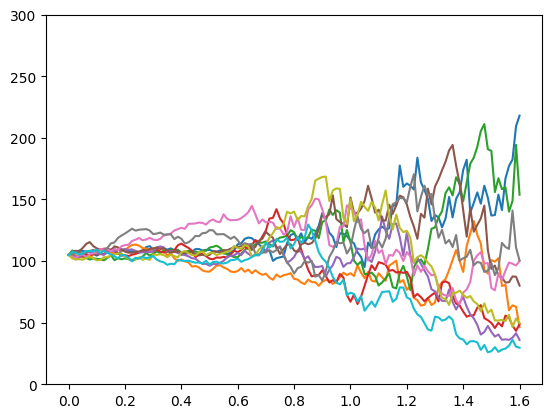

In [262]:
y, x = simulate_GBM(market_model(), "euler", 10 , 128)

print(len(x))

for i in range(0, 10):
    plt.plot(x, y[i,:])
    plt.ylim(0,300)
plt.show()

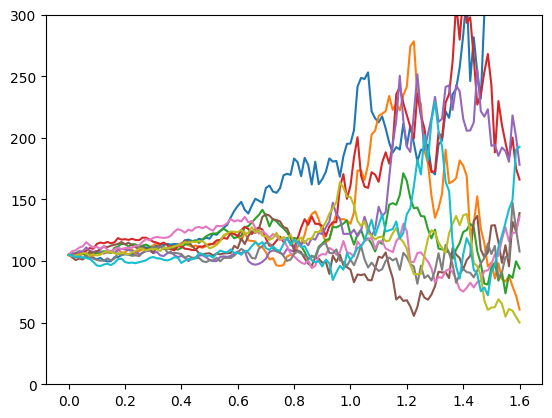

In [196]:
y, x = simulate_GBM(market_model(), "explicit", 10 , 128)

for i in range(0, 10):
    plt.plot(x, y[i,:])
    plt.ylim(0,300)
plt.show()

# Question 3

# Question 4

In [191]:
a = [1,2]
b = [[1], [2]]
c = 1

print(a.isArray())

AttributeError: 'list' object has no attribute 'isArray'